In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
test_id = test_df['PassengerId']
train_df.drop(columns = 'PassengerId', inplace = True)
test_df.drop(columns = 'PassengerId', inplace = True)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [6]:
train_df.shape

(891, 11)

In [7]:
test_df.shape

(418, 10)

In [8]:
def get_summary(df):
    summary = pd.DataFrame()
    summary['dtypes'] = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary['missing'] = df.isna().sum()
    summary['%missing'] = df.isna().sum() / len(df)
    summary['nunique'] = df.nunique()
    summary['Count'] = df.count().values
    return summary

summary_train = get_summary(train_df)
summary_test = get_summary(test_df)

In [9]:
summary_train.style.background_gradient(cmap = 'Blues')

,dtypes,missing,%missing,nunique,Count
Survived,int64,0,0.000000,2,891
Pclass,int64,0,0.000000,3,891
Name,object,0,0.000000,891,891
Sex,object,0,0.000000,2,891
Age,float64,177,0.198653,88,714
SibSp,int64,0,0.000000,7,891
Parch,int64,0,0.000000,7,891
Ticket,object,0,0.000000,681,891
Fare,float64,0,0.000000,248,891
Cabin,object,687,0.771044,147,204


In [10]:
summary_test.style.background_gradient(cmap = 'Blues')

,dtypes,missing,%missing,nunique,Count
Pclass,int64,0,0.000000,3,418
Name,object,0,0.000000,418,418
Sex,object,0,0.000000,2,418
Age,float64,86,0.205742,79,332
SibSp,int64,0,0.000000,7,418
Parch,int64,0,0.000000,8,418
Ticket,object,0,0.000000,363,418
Fare,float64,1,0.002392,169,417
Cabin,object,327,0.782297,76,91
Embarked,object,0,0.000000,3,418


In [11]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)
train_df['Embarked'].isna().sum()

0

In [12]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
categorical_columns = train_df.select_dtypes(include = ['object', 'int64']).columns.tolist()
categorical_columns.remove('Name')
categorical_columns.remove('Ticket')
categorical_columns.remove('Cabin')
numerical_columns = train_df.select_dtypes(include = ['float64']).columns.tolist()
print(f'Categorical columns: {categorical_columns}')
print(f'Numerical columns: {numerical_columns}')

Categorical columns: ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
Numerical columns: ['Age', 'Fare']


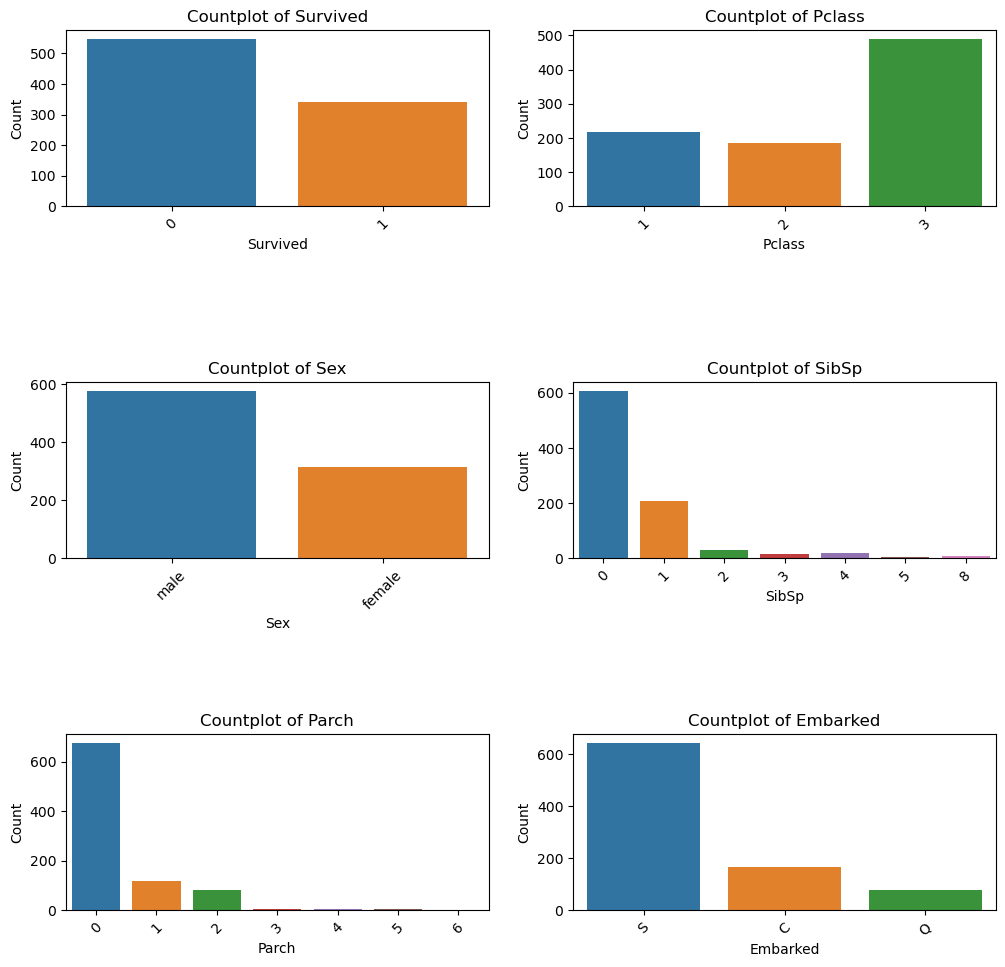

In [14]:
columns_per_row = 2
num_rows = len(categorical_columns) // columns_per_row
if num_rows % columns_per_row != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, columns_per_row, figsize = (12, 4 * num_rows))
fig.subplots_adjust(hspace = 1.0)
for i, feature in enumerate(categorical_columns):
    row_index = i // 2
    col_index = i % 2
    ax = axes[row_index, col_index]
    sns.countplot(data = train_df, x = feature, ax = ax)
    ax.set_title(f'Countplot of {feature}')
    ax.set_ylabel('Count')
    ax.set_xlabel(feature)
    ax.tick_params(axis = 'x', rotation = 45)

for i in range(len(categorical_columns), num_rows * columns_per_row):
    fig.delaxes(axes.flatten()[i])

plt.show()

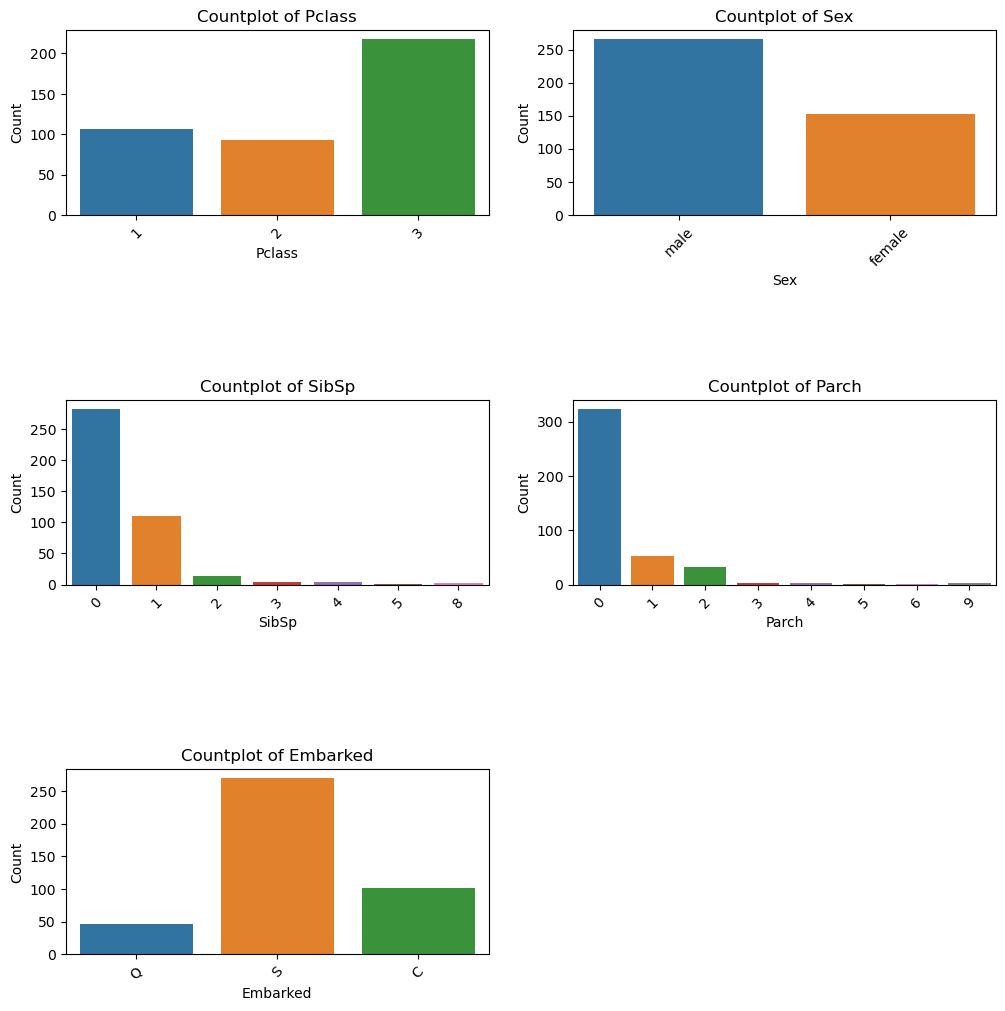

In [15]:
columns_per_row = 2
categorical_columns_test = [col for col in categorical_columns if col != 'Survived']
num_rows = len(categorical_columns_test) // columns_per_row
if len(categorical_columns_test) % columns_per_row != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(12, 4 * num_rows))
fig.subplots_adjust(hspace=1.0)

for i, feature in enumerate(categorical_columns_test):
    row_index = i // columns_per_row
    col_index = i % columns_per_row
    ax = axes[row_index, col_index]
    sns.countplot(data=test_df, x=feature, ax=ax)
    ax.set_title(f'Countplot of {feature}')
    ax.set_ylabel('Count')
    ax.set_xlabel(feature)
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for i in range(len(categorical_columns_test), num_rows * columns_per_row):
    fig.delaxes(axes.flatten()[i])

plt.show()

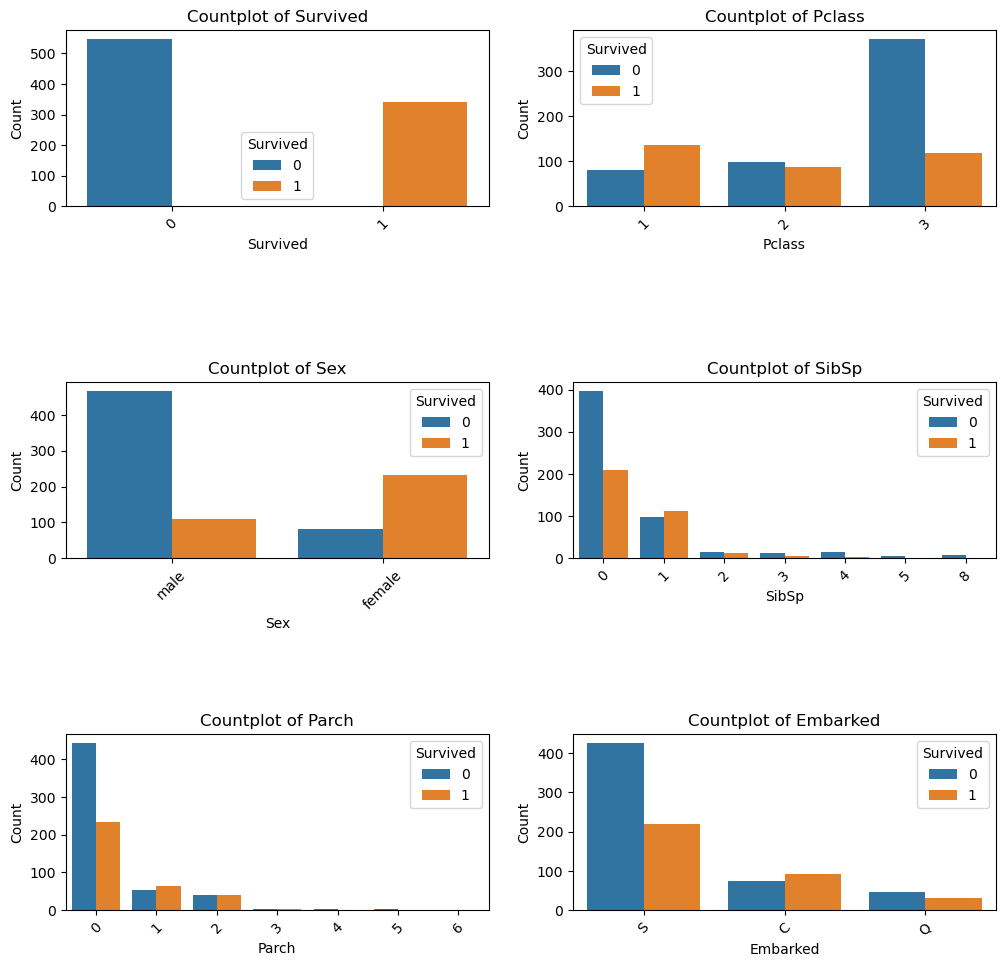

In [16]:
columns_per_row = 2
num_rows = len(categorical_columns) // columns_per_row
if num_rows % columns_per_row != 0:
    num_rows += 1
fig, axes = plt.subplots(num_rows, columns_per_row, figsize = (12, 4 * num_rows))
fig.subplots_adjust(hspace = 1.0)
for i, feature in enumerate(categorical_columns):
    row_index = i // 2
    col_index = i % 2
    ax = axes[row_index, col_index]
    sns.countplot(data = train_df, x = feature, ax = ax, hue = 'Survived')
    ax.set_title(f'Countplot of {feature}')
    ax.set_ylabel('Count')
    ax.set_xlabel(feature)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.legend(title = 'Survived')

for i in range(len(categorical_columns), num_rows * columns_per_row):
    fig.delaxes(axes.flatten()[i])

plt.show()

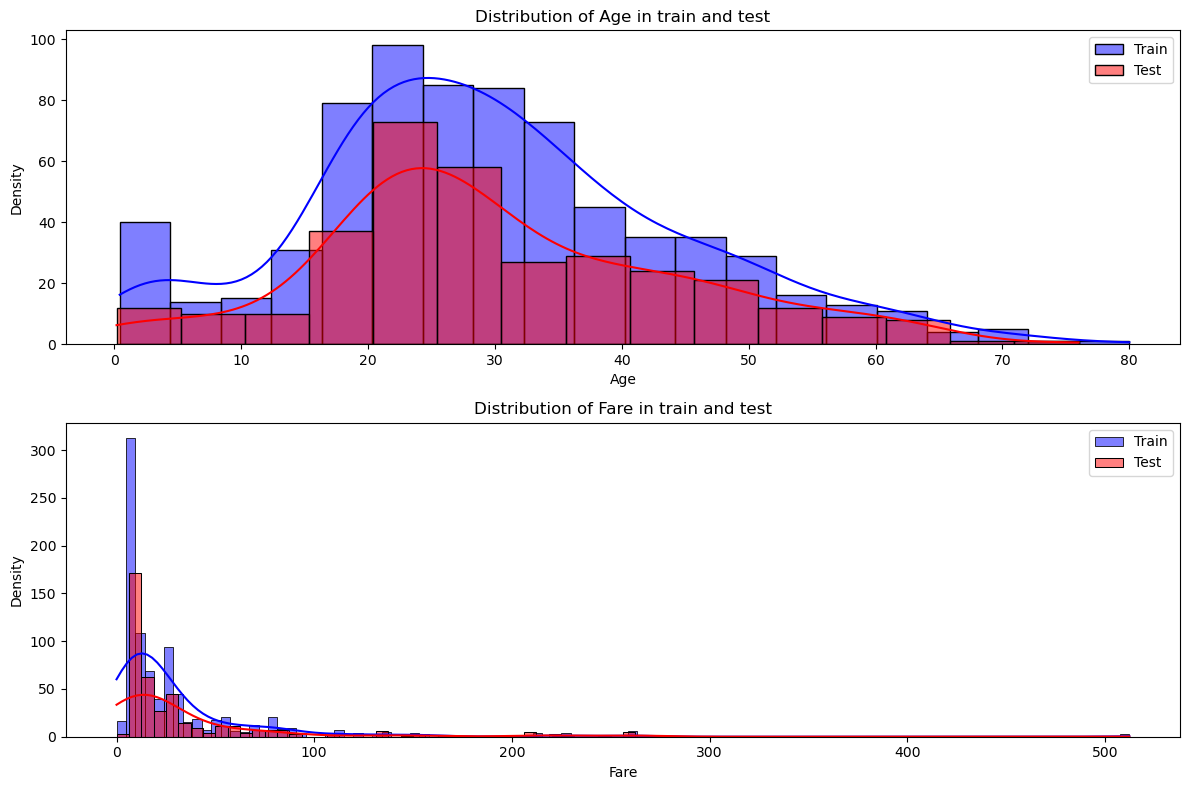

In [17]:
num_rows = len(numerical_columns)
fig, axes = plt.subplots(num_rows, 1, figsize = (12, 4 * num_rows))
for i, column in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(train_df[column], kde = True, color = 'blue', label = 'Train', ax = ax)
    sns.histplot(test_df[column], kde = True, color = 'red', label = 'Test', ax = ax)
    ax.set_title('Distribution of {} in train and test'.format(column))
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

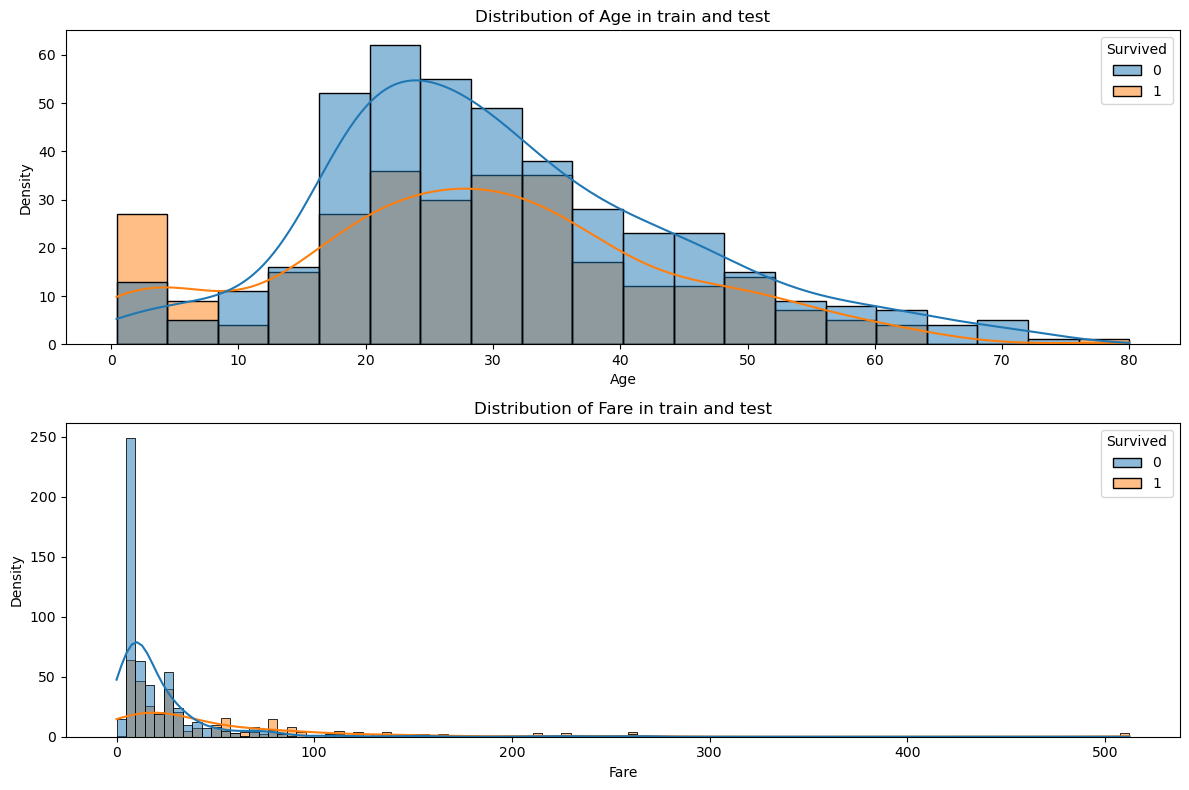

In [18]:
num_rows = len(numerical_columns)
fig, axes = plt.subplots(num_rows, 1, figsize = (12, 4 * num_rows))
for i, column in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(data = train_df, x = column, kde = True, color = 'blue', hue = 'Survived', ax = ax, legend = True)
    ax.set_title('Distribution of {} in train and test'.format(column))
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [19]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace = True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace = True)

In [20]:
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace = True)

In [21]:
train_df['Cabin'].fillna('No Cabin', inplace = True)
test_df['Cabin'].fillna('No Cabin', inplace = True)
train_df['Ticket'].fillna('No ticket data', inplace = True)
test_df['Ticket'].fillna('No ticket data', inplace = True)

In [22]:
RED = '\033[91m'
RESET = '\033[0m'
significance_level = 0.05
def chi_square(df, target):
    for feature in df.columns:
        if feature != target:
            contingency_table = pd.crosstab(df[feature], df[target])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            if p < significance_level:
                print(f'{feature} has a significant relationship with {target}')
            else:
                print(RED + f'{feature} does not have a significant relationship with {target}' + RESET)

target = 'Survived'
chi_square(train_df, target)

Pclass has a significant relationship with Survived
Name does not have a significant relationship with Survived
Sex has a significant relationship with Survived
Age has a significant relationship with Survived
SibSp has a significant relationship with Survived
Parch has a significant relationship with Survived
Ticket has a significant relationship with Survived
Fare has a significant relationship with Survived
Cabin has a significant relationship with Survived
Embarked has a significant relationship with Survived


In [23]:
train_df.drop(columns = 'Name', inplace = True)
test_df.drop(columns = 'Name', inplace = True)

In [24]:
def fill_cabin(df):
    if df != 'No Cabin':
        return 'Cabin allocated'
    else:
        return 'No Cabin'
    
train_df['Cabin'] = train_df['Cabin'].apply(fill_cabin)

In [25]:
test_df['Cabin'] = test_df['Cabin'].apply(fill_cabin)

In [26]:
train_df.drop(columns = 'Ticket', inplace = True)
test_df.drop(columns = 'Ticket', inplace = True)

In [27]:
train_df['Age_cat'] = pd.cut(train_df['Age'], bins = [0, 12, 18, 40, 65, 100], labels = ['Child', 'Teen', 'Adult', 'MidAdults', 'Elderly'])
test_df['Age_cat'] = pd.cut(test_df['Age'], bins = [0, 12, 18, 40, 65, 100], labels = ['Child', 'Teen', 'Adult', 'MidAdults', 'Elderly'])

In [28]:
train_df['Fare_cat'] = pd.cut(train_df['Fare'], bins = [float('-inf'), 7.91, 14.454, 31, 99, 250, float('inf')], labels = ['Group0', 'Group1', 'Group2', 'Group3', 'Group4', 'Group5'])
test_df['Fare_cat'] = pd.cut(test_df['Fare'], bins = [float('-inf'), 7.91, 14.454, 31, 99, 250, float('inf')], labels = ['Group0', 'Group1', 'Group2', 'Group3', 'Group4', 'Group5'])

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ['Age', 'Fare']
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df[columns_to_scale] = scaler.fit_transform(test_df[columns_to_scale])

In [30]:
le = LabelEncoder()
for column in train_df.select_dtypes(include = ['object', 'category']).columns.tolist():
    train_df[column] = le.fit_transform(train_df[column])
    test_df[column] = le.fit_transform(test_df[column])

In [31]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_cat,Fare_cat
0,0,3,1,-0.592481,1,0,-0.502445,1,2,0,0
1,1,1,0,0.638789,1,0,0.786845,0,0,0,3
2,1,3,0,-0.284663,0,0,-0.488854,1,2,0,1
3,1,1,0,0.407926,1,0,0.420730,0,2,0,3
4,0,3,1,0.407926,0,0,-0.486337,1,2,0,1


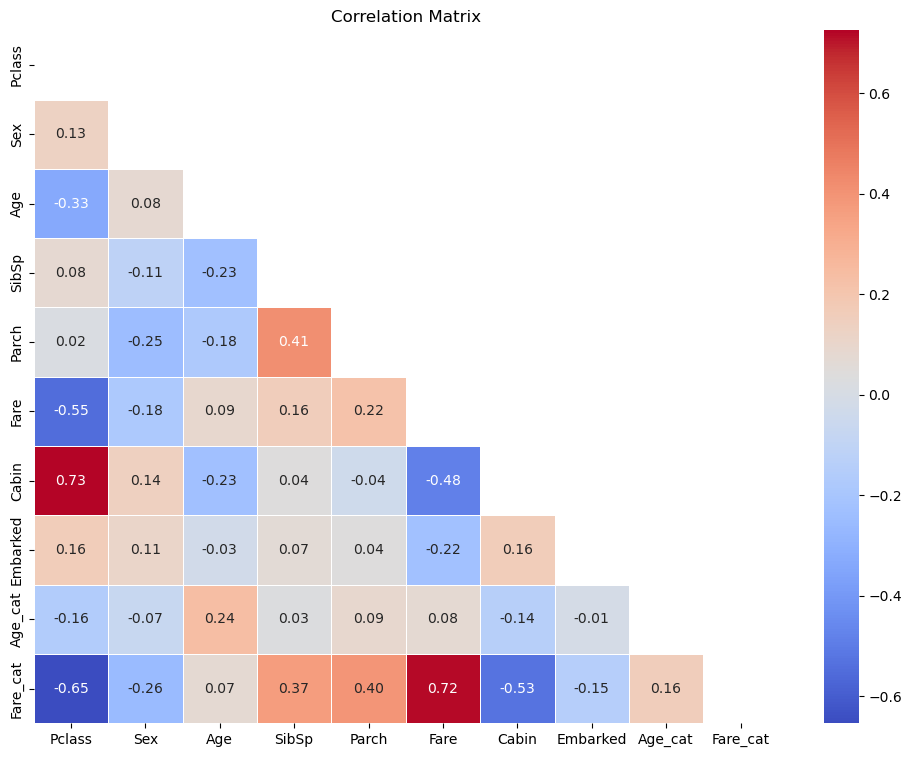

In [32]:
correlation_matrix = train_df.drop(columns = 'Survived').corr()
plt.figure(figsize = (12, 9))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data = correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5, mask = mask)
plt.title('Correlation Matrix')
plt.show()

In [33]:
import warnings
warnings.filterwarnings("ignore")
X = train_df.drop(columns = 'Survived')
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
}

f1_scores = {}
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

for name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average = "weighted")
    f1_scores[name] = f1

for name, score in f1_scores.items():
    print(f"{name}: {score}")

Logistic Regression: 0.8204168769615436
Random Forest: 0.83204486023412
Gradient Boosting: 0.8253100360553113
SVM: 0.8194015097710449


In [34]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30], 
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Average weighted F1 score: {}'.format(f1))

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 100}
Average weighted F1 score: 0.8311891835182417


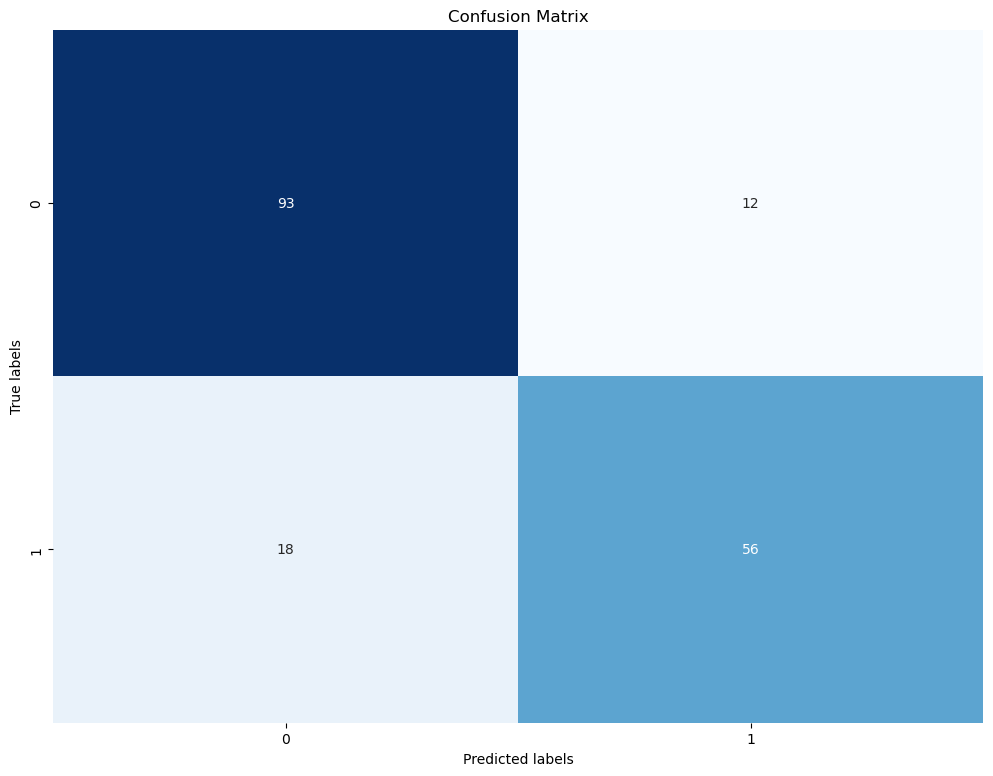

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
best_model.fit(X, y)
predictions = best_model.predict(test_df)
predicted_df = pd.DataFrame({
    'PassengerId': test_id,
    'Survived': predictions
})
predicted_df.to_csv('predictions.csv', index=False)